# Notebook 0: generate plots

Generate subfigures for manuscript Figure 1 and Figure S2.

In [1]:
import toytree
import ipcoal
import numpy as np

# print versions
for pkg in [toytree, ipcoal]:
    print(pkg.__name__, pkg.__version__)

toytree 3.0.dev8
ipcoal 0.4.dev4


### Species tree

In [2]:
HEIGHTS = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 200_000,
    5: 400_000,
    6: 600_000,
}

In [3]:
sptree = toytree.tree("(((A,B),C),D);")
sptree = sptree.mod.edges_set_node_heights(HEIGHTS)
sptree = sptree.set_node_data("Ne", default=100_000)
sptree.draw('p');

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="300.0px" viewBox="0 0 300.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t12a9d1b0b0fb43a4b6866635aab1051c"> 0 1 2 3 4 5 6 A B C D 0 200000 400000 600000

### An embedded genealogy

In [4]:
GHEIGHTS = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 100_000,
    8: 120_000,
    9: 300_000,
    10: 450_000,
    11: 650_000,
    12: 800_000,
}

In [5]:
gtree = toytree.tree("(((A1,A2),(A3,(B1,B2))),(C1,D1));")
gtree = gtree.mod.edges_set_node_heights(GHEIGHTS)
gtree.draw('p');

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="300.0px" viewBox="0 0 300.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t5302ba3a880d49ce8dd9a93d1a7a4e1a"> 0 1 2 3 4 5 6 7 8 9 10 11 12 A1 A2 A3 B1 B2 C1 D1 0 250000 500000 750000

### IMAP

In [6]:
IMAP = {
    "A": ["A1", "A2", "A3"],
    "B": ["B1", "B2"],
    "C": ["C1"],
    "D": ["D1"],
}

### Get embedding table

In [8]:
ipcoal.smc.get_genealogy_embedding_table(sptree, gtree, IMAP)

,start,stop,st_node,neff,nedges,coal,edges,dist
0,0,100000,0,100000,3,7,"[0, 1, 2]",100000
1,100000,200000,0,100000,2,<NA>,"[2, 7]",100000
2,0,120000,1,100000,2,8,"[3, 4]",120000
3,120000,200000,1,100000,1,<NA>,[8],80000
4,0,400000,2,100000,1,<NA>,[5],400000
5,0,600000,3,100000,1,<NA>,[6],600000
6,200000,300000,4,100000,3,9,"[2, 7, 8]",100000
7,300000,400000,4,100000,2,<NA>,"[7, 9]",100000
8,400000,450000,5,100000,3,10,"[5, 7, 9]",50000
9,450000,600000,5,100000,2,<NA>,"[5, 10]",150000


### Generate figures
A general function is available for visualizing hte edge probabilities in `ipcoal`. This is used to generate the plots for supplementary figure S2.

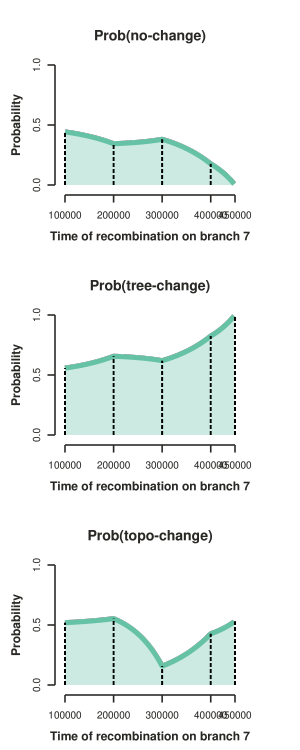

In [9]:
ipcoal.smc.plot_edge_probabilities(
    species_tree=sptree,
    genealogy=gtree,
    imap=IMAP,
    branch=7,
)

### Custom function for Fig. 1

To generate figure panels for Figure 1 of the manuscript we use the function below and then used Inkscape to combine and further color the plots.

In [10]:
from typing import Sequence, Dict
import toyplot, toyplot.svg
from ipcoal.smc.ms_smc import *

In [279]:
def plot_edge_probabilities(
    species_tree: toytree.ToyTree,
    genealogy: toytree.ToyTree,
    imap: Dict[str, Sequence[str]],
    branch: int,
    etype: str,
    **kwargs,
) -> toyplot.canvas.Canvas:
    """Return a toyplot canvas with probabilities along an edge.
    
    Plot probability of an event type (no-change, tree-change, topo-change) over an edge.
    """
    canvas = toyplot.Canvas(height=kwargs.get("height", 250), width=kwargs.get("width", 800),)
    ax0 = canvas.cartesian(margin=65, padding=0)

    # Select a branch to plot and get its relations
    branch = genealogy[branch]
    bidx = branch.idx
    sidx = branch.get_sisters()[0].idx
    pidx = branch.up.idx

    # Get genealogy embedding table
    etable = get_genealogy_embedding_table(species_tree, genealogy, imap)
    btable = get_genealogy_embedding_edge_path(etable, bidx)
    
    # Plot probabilities of change types over a single branch
    times = np.linspace(branch.height, branch.up.height, 200, endpoint=False)
    
    # get probabilities
    pt_nochange_tree = [
        get_probability_tree_unchanged_given_b_and_tr_from_table(
        etable, bidx, itime) for itime in times
    ]
    pt_nochange_topo = [
        get_probability_topology_unchanged_given_b_and_tr_from_table(
        etable, bidx, sidx, pidx, itime) for itime in times
    ]

    # add line and fill for probabilities
    if etype == "no-change":
        ax0.fill(times, pt_nochange_tree, opacity=0.7)
    elif etype == "tree-change":
        ax0.fill(times, 1 - np.array(pt_nochange_tree), opacity=0.7)
    elif etype == "topo-change":
        ax0.fill(times, 1 - np.array(pt_nochange_topo), opacity=0.7)
    else:
        raise ValueError("etype arg not recognized")

    # style the axes
    ax1 = ax0.share('y', ymax=1.0, ymin=0)
    ax1.x.ticks.locator = toyplot.locator.Explicit(list(etable.start))
    ax1.x.domain.min = 0
    ax1.x.domain.max = gtree[-1].height
    ax1.x.domain.show = ax1.y.domain.show = False
    ax1.x.ticks.show = ax1.y.ticks.show = True
    ax1.x.ticks.far = ax1.y.ticks.far = 0
    ax1.x.ticks.near = ax1.y.ticks.near = 7.5
    #ax1.x.ticks.labels.offset = ax1.y.ticks.labels.offset = 15
    #ax1.x.label.text = f"Time of event (generations)"
    #ax1.label.offset = 20
    ax1.x.ticks.labels.show = False
    ax1.y.label.text = "Probability"
    
    ax1.x.label.offset = ax0.y.label.offset = 35
    ax1.x.spine.style['stroke-width'] = ax0.y.spine.style['stroke-width'] = 5
    ax1.x.ticks.style['stroke-width'] = ax0.y.ticks.style['stroke-width'] = 5
    
    ax1.y.ticks.locotor = toyplot.locator.Explicit([0, 0.5, 1.0])
    ax0.x.spine.style["stroke-width"] = 5
    ax0.x.domain.min = 0
    ax0.x.domain.max = gtree[-1].height
    ax0.x.domain.show = False
    ax0.x.ticks.labels.show = False
    return canvas, ax0


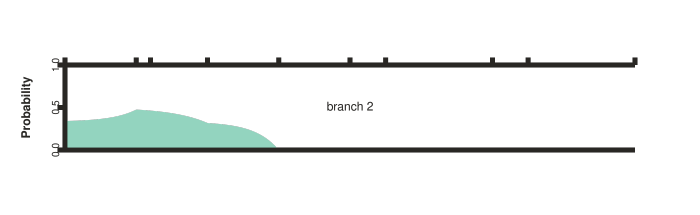

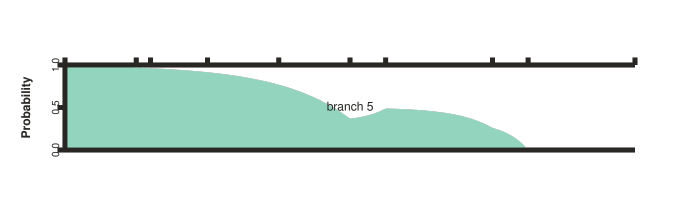

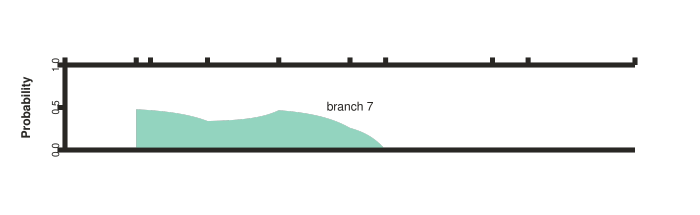

In [285]:
for branch in [2, 5, 7]:
    canvas, axes = plot_edge_probabilities(sptree, gtree, IMAP, branch=branch, etype="no-change", width=700, height=215)
    canvas.text(canvas.width / 2, canvas.height / 2, f"branch {branch}")
    toyplot.svg.render(canvas, f"../manuscript/figures/panels/prob-no-change-branch-{branch}.svg")
    display(canvas)

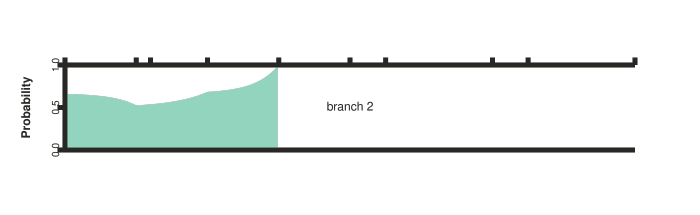

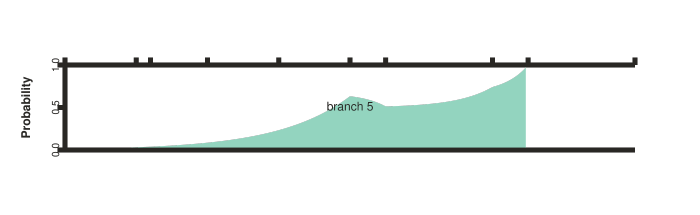

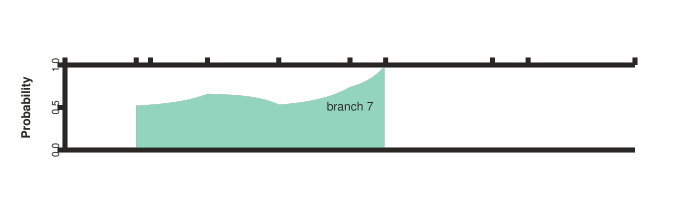

In [284]:
for branch in [2, 5, 7]:
    canvas, axes = plot_edge_probabilities(sptree, gtree, IMAP, branch=branch, etype="tree-change", width=700, height=215)
    canvas.text(canvas.width / 2, canvas.height / 2, f"branch {branch}")
    toyplot.svg.render(canvas, f"../manuscript/figures/panels/prob-tree-change-branch-{branch}.svg")
    display(canvas)

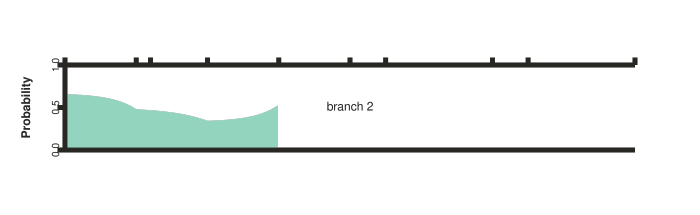

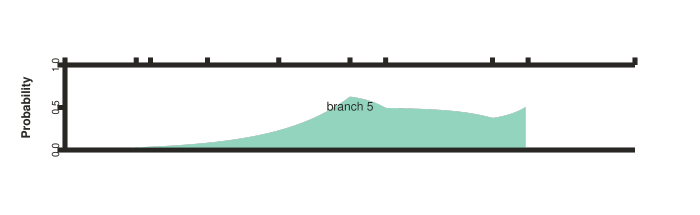

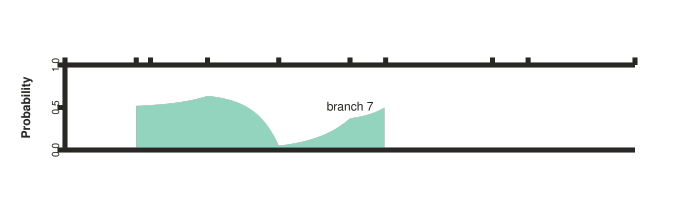

In [283]:
for branch in [2, 5, 7]:
    canvas, axes = plot_edge_probabilities(sptree, gtree, IMAP, branch=branch, etype="topo-change", width=700, height=215)
    canvas.text(canvas.width / 2, canvas.height / 2, f"branch {branch}")
    toyplot.svg.render(canvas, f"../manuscript/figures/panels/prob-topo-change-branch-{branch}.svg")
    display(canvas)